<a href="https://colab.research.google.com/github/pipeton8/pattern-recognition/blob/main/assignments/3%20-%20Skin%20lesion%20classifier/assignment3_fdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Skin cancer recognition

(c) Felipe del Canto, June 2021

---

# Skin cancer recognition

In [ ]:
# Set preLoad = True if loading features from file (recommended)
preLoad = True

# 0. Preamble

## Load libraries

In [ ]:
from IPython.display import clear_output

!pip install scipy==1.2
!pip3 install pybalu==0.2.5
clear_output()
print('PyBalu library installed.')

PyBalu library installed.


In [ ]:
# General purpose
import os
from   google.colab import files

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd

import cv2

# Utilities
from   seaborn                  import heatmap
from   tqdm.auto                import tqdm
from   skimage.color            import rgb2gray, rgb2hsv
from   pybalu.feature_selection import clean

# Image processing
from   skimage         import feature
from   skimage.filters import threshold_otsu, threshold_minimum
from   scipy.ndimage   import binary_closing, binary_dilation, binary_fill_holes
from   scipy           import ndimage

# Features
from   pybalu.feature_extraction import lbp_features, hog_features, basic_geo_features

# Model selection
from   sklearn.model_selection import StratifiedKFold

# Metrics
from   sklearn.metrics import confusion_matrix

## Load database

In [ ]:
!wget 'https://github.com/pipeton8/pattern-recognition/raw/main/assignments/databases/skin.zip' -O 'skin.zip'
!unzip -o -q 'skin.zip'
!rm 'skin.zip'
clear_output()
print("Database Loaded")

Database Loaded


## Load features

In [ ]:
if preLoad:
  !gdown --id '1Z6NUp49Q36ycTO9bleuKTXtdRISu00h0'
  clear_output()
  skin = pd.read_csv('skin.csv')
  print("Features Loaded")

Features Loaded


## Image manipulation functions

In [ ]:
def getImageList(prefix, dataset, classNumber):
  path = dataset + '/' + 'class_{:d}'.format(classNumber)

  imgList = os.listdir(path)
  imgList = [imgList[i] for i in range(len(imgList)) if imgList[i].find(prefix) != -1 ]

  return imgList

def ImageLoad(dataset, classNumber, name):
  st   = dataset + '/' + 'class_{:d}'.format(classNumber) + '/' + name

  return plt.imread(st)

In [ ]:
def remove_hair(image):
    # source: https://stackoverflow.com/questions/66508552/hair-removal-from-an-image-method
    # Original code: https://github.com/sunnyshah2894/DigitalHairRemoval

    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
    return final_image

In [ ]:
def segment_lesion(image):
  final_seg = np.zeros_like(image[:,:,0])

  for channel in range(img.shape[2]+1): 
    # Retrieve channel or grayscale image
    try:
      img2seg = image[:,:,channel]
    except:
      img2seg = rgb2gray(image)

    img2seg = segment_channel(img2seg)

    final_seg = final_seg + img2seg/4

    # Create mask to delete borders 
    mask = np.zeros_like(final_seg, dtype='int')
    mask[10:-10, 10:-10] = 1

    # Apply mask and fill holes
    final_seg = binary_fill_holes(final_seg * mask > 0)

    # Keep biggest region
    final_seg = retain_biggest_region(final_seg)

  return final_seg

def segment_channel(img2seg):
  # Sometimes, local maxima are not found
  try:
    img2seg_min  = (img2seg < threshold_minimum(img2seg)).astype(float)
  except:
    img2seg_min  = np.ones_like(img2seg)

  img2seg_otsu = (img2seg < threshold_otsu(img2seg)).astype(float)

  return ((img2seg_min+img2seg_otsu) >= 1).astype(float)

def retain_biggest_region(image):
  label_im, nb_labels = ndimage.label(image)

  sizes = ndimage.sum(image, label_im, range(nb_labels + 1))
  
  mask = sizes == max(sizes)
  
  binary_img = mask[label_im]

  return binary_img

## Data processing functions

In [ ]:
# Split dataset for classification (only for holdout)
def prepareData(df, test=False):   
  if test:
    df_train = df[df['set'] != 'test']
    df_test  = df[df['set'] == 'test']
  
  else:
    df_train = df[df['set'] == 'train']
    df_test  = df[df['set'] == 'val']
  
  Xtrain, ytrain = df_train.iloc[:,3:].to_numpy(), df_train['class'].to_numpy()
  Xtest , ytest  = df_test.iloc[:,3:].to_numpy() , df_test['class'].to_numpy()

  Xtrain, Xtest  = preprocess(Xtrain, Xtest)

  return Xtrain, ytrain, Xtest, ytest

In [ ]:
# Preprocessing function
def preprocess(Xtrain, Xtest):
    # Select columns that are not constant and for those which are highly correlated, 
    # leave only one occurrence. The choice is done only using the train set.
    # For val/test df just delete columns and normalize

    # Clean
    clean_selection = clean(Xtrain)

    Xtrain = Xtrain[:,clean_selection]
    Xtest  = Xtest[:,clean_selection]

    # Normalize
    Xtrain, a, b = minmax(Xtrain)
    Xtest        = Xtest*a + b

    return Xtrain, Xtest

In [ ]:
def minmax(X):
  min = X.min(axis=0) # vector of column-wise minima
  max = X.max(axis=0) # vector of column-wise maxima

  range         = max - min   # vector of column-wise ranges
  scale_coef    = 1/range     # scale coefficient
  position_coef = -min/range  # position coefficient

  # Return normalized features and coefficients to normalize test set
  return X*scale_coef + position_coef, scale_coef, position_coef

## Classification functions

In [ ]:
# Use selector to transform features
def selectOrTransform(sel, Xtrain, ytrain, Xtest):
  sel.fit(Xtrain, ytrain)

  return sel.transform(Xtrain), sel.transform(Xtest)

# Use classifier to predict outcomes
def classify(clf, Xtrain, ytrain, Xtest):
  clf.fit(Xtrain, ytrain)

  return clf.predict(Xtrain), clf.predict(Xtest)

## Score functions

In [ ]:
def getMetrics(ytrain, ypred_train, ytest, ypred_test):

  # Get training and testing confusion matrices
  Ctrain = confusion_matrix(ytrain, ypred_train)
  Ctest  = confusion_matrix(ytest , ypred_test)

  return Ctrain, Ctest

In [ ]:
def displayMetrics(Ctrain, Ctest, cv = False, test=False, mode='heatmap'):
  
  # Compute accuracy scores
  trainAcc = np.mean(np.trace(Ctrain)/np.sum(Ctrain,(0,1)) * 100)
  testAcc  = np.mean(np.trace(Ctest)/np.sum(Ctest,(0,1)) * 100)
  
  # If CV, compute average confusion matrix
  if cv:
    Ctrain = np.mean(Ctrain, axis=2)
    Ctest  = np.mean(Ctest , axis=2)

  # Compute 
  TPR      = Ctest[0,0]/(Ctest[0,0]+Ctest[0,1]) * 100
  FPR      = Ctest[1,0]/(Ctest[1,0]+Ctest[1,1]) * 100

  setName = 'Test'*test + 'Validation'*(1-test)

  print(f'Training Accuracy = {trainAcc:.2f}%')
  print(f'{setName} Accuracy = {testAcc:.2f}%',end='\n\n')
  print(f'True Positive Rate  (TPR) = {TPR:.2f}%')
  print(f'False Negative Rate (FNR) = {100-TPR:.2f}%')
  print(f'False Positive Rate (FPR) = {FPR:.2f}%')
  print(f'True Negative Rate  (TPR) = {100-FPR:.2f}%')

  print("\nTrain Confusion Matrix")
  printConfusionMatrix(Ctrain,mode)

  print(f"\n{setName} Confusion Matrix")
  printConfusionMatrix(Ctest,mode)

In [ ]:
# Confusion matrix print function
def printConfusionMatrix(C, mode='heatmap'):
  if mode == 'heatmap':

    heatmap(C, annot=True, cbar=None, cmap="Blues", fmt='.1f')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")

    labels = ['Bening', 'Malignant']
    plt.xticks([0.5,1.5], labels)
    plt.yticks([0.5,1.5], labels, va = 'center')

    plt.show()

  else:  
    print('\nConfusion matrix:')
    print(C)

  return None

## Experiment function

In [ ]:
def experiment(df, sel, clf, cv=None, display=True, test=False):
  if cv is not None:
    # Remove test observations
    df = df[df['set'] != 'test']

    # Create class vector to stratify
    y = df['class'].to_numpy()

    # Define Stratified KFold object
    skf = StratifiedKFold(n_splits=cv, random_state=0)

    # Execute CV
    Ctrain, Ctest = run_cv(df,y,skf,sel,clf)

    # Display metrics
    displayMetrics(Ctrain, Ctest, cv=True)

    return None

  # Split data
  Xtrain, ytrain, Xtest, ytest = prepareData(df, test=test)

  # Select or transform features
  Xtrain, Xtest = selectOrTransform(sel, Xtrain, ytrain, Xtest)

  # Classify
  ypred_train, ypred_test = classify(clf, Xtrain, ytrain, Xtest)

  # Obtain confusion matrices
  Ctrain, Ctest = getMetrics(ytrain, ypred_train, ytest, ypred_test)

  # Display
  if display:
    displayMetrics(Ctrain, Ctest)

    return None

  return Ctrain, Ctest

In [ ]:
def run_cv(df, y, skf, sel, clf):
  # Initialize confusion matrices
  Ctrain, Ctest = np.zeros((2,2,cv)), np.zeros((2,2,cv))

  for i,(train_index, test_index) in enumerate(skf.split(np.zeros_like(y), y)):
    # For each fold, redefine test/train sets accordingly
    df['set'].iloc[train_index] = 'train'
    df['set'].iloc[test_index]  = 'test'

    # Run experiment
    newCtrain, newCtest = experiment(df,sel,clf, display=False)

    # Update metrics
    Ctrain[:,:,i] = newCtrain
    Ctest[:,:,i]  = newCtest
    
  return Ctrain, Ctest

# 1. Image analysis

## 1. Hair removal

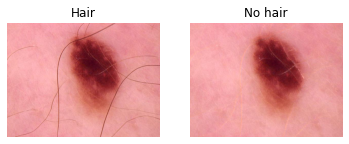

In [ ]:
# Parameters
imageName = 'ISIC_0024501.jpg'
setToLoad = 'train'
classToLoad = 0

# Create plots and title
fig, axs = plt.subplots(1, 2)#, sharex = 'all', sharey = 'all')
#fig.patch.set_facecolor('blueviolet')

# Load image
img = ImageLoad(setToLoad,classToLoad,imageName)

# Show image with hair
axs[0].set_title('Hair')#,color='white')
axs[0].imshow(img)
axs[0].set_axis_off()

# Show image with no hair
axs[1].set_title('No hair')#,color='white')
axs[1].imshow(remove_hair(img))
axs[1].set_axis_off()

## 2. Segment lesion

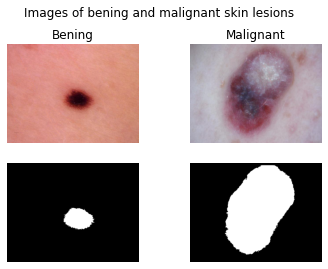

In [ ]:
# Parameters
imagesToLoad = ['ISIC_0032228.jpg', 'ISIC_0033534.jpg']

# Create plots and title
fig, axs = plt.subplots(2, 2)#, sharex = 'all', sharey = 'all')
#fig.patch.set_facecolor('blueviolet')
fig.suptitle("Images of bening and malignant skin lesions",y=1.01)#,color='white')

for k in range(2):
  # Store image of corresponding class from the train set  
  img = remove_hair(ImageLoad('train',k,imagesToLoad[k]))

  final_seg = segment_lesion(img)

  # Set title
  image_title = "Bening"*(k == 0) + "Malignant"*(k==1)
  axs[0,k].set_title("{:s}".format(image_title))#,color='white')

  axs[0,k].imshow(img)
  axs[0,k].set_axis_off()

  axs[1,k].imshow(final_seg, cmap = 'gray')
  axs[1,k].set_axis_off()

# 2. Feature extraction

In [ ]:
## General parameters
K  = 2                  # number of classes
N  = { 'train' : 1350,  # number of images per class in train folder
       'test'  : 300,   # number of images per class in test  folder
       'val'   : 150}   # number of images per class in val   folder

## LBP parameters
Mlbp    = 59   # size of the LBP vector
lbpDict = {'hdiv'    : 1,
           'vdiv'    : 1,
           'mapping' : 'nri_uniform'}

## HoG parameters
hogDict   = {'v_windows' : 16,  # number of vertical windows
             'h_windows' : 10,  # number of horizontal windows
             'n_bins'    : 9}   # number of bins

## Number of channels: 3RGB + 3HSV
channels = 6

## Number of columns of feature matrices
colsLBP   = Mlbp * lbpDict['hdiv'] * lbpDict['vdiv']
colsHog   = hogDict['v_windows'] * hogDict['h_windows'] * hogDict['n_bins']

## Column names for dataFrame
colsLBP_names = [f'lbp_{i%colsLBP+1}_{["r","g","b","h","s","v"][i//colsLBP]}' for i in range(colsLBP*channels)]
colsHog_names = [f'hog_{i%colsHog+1}_{["r","g","b","h","s","v"][i//colsHog]}' for i in range(colsHog*channels)]

## Start loop
for setName in ['train', 'val', 'test']:
  if preLoad:
    print("Features already loaded")
    break

  print(f'Loading images and extracting features for {setName} set...')
  for j in range(K):

    ## Initialize DataFrame
    df = pd.DataFrame(columns=('name','set','class',*colsLBP_names, *colsHog_names, 'roundness', 'danielsson_factor','eccentricity'))
    loc = 0

    # Get list of image filenames
    imgsToLoad = getImageList('ISIC',setName,j)

    print(f'Extracting features: class {j+1}/{K}')
    for i in tqdm(range(N[setName])):
      # Initialize Row
      newRow = [imgsToLoad[i], setName, j]
      
      # Read image, remove hair and segment lesion
      img     = 255*remove_hair(ImageLoad(setName, j, imgsToLoad[i]))
      segmented_lesion = segment_lesion(img).astype(int)

      # Stack HSV image as 3 additional channels
      img_hsv = rgb2hsv(img)
      img = np.dstack((img,img_hsv))

      # Initialize feature vectors
      newLbp   = np.array([0])
      newHog   = np.array([0])

      for channel in range(img.shape[2]):
        # Classic LBP
        f        = lbp_features(img[:,:,channel], **lbpDict)
        newLbp   = np.concatenate((newLbp,f))

        # Histogram of gradients (HoG)
        f        = hog_features(img[:,:,channel], **hogDict)
        newHog   = np.concatenate((newHog,f))

      # Obtain basic geometric features of lesion
      basic_features = basic_geo_features(segmented_lesion)

      # Keep only: Roundness, Danielsson factor and Eccentricity
      basic_features = basic_features[[6,7,15]]

      # Add row
      newRow = newRow + list(newLbp[1:]) + list(newHog[1:]) + list(basic_features)
      df.loc[loc] = newRow
      loc += 1  

    df.to_csv(f'skin_{setName}_{j}.csv', index=False)
    files.download(f'skin_{setName}_{j}.csv')

# Join all DFs and download
if not preLoad:
  df = pd.DataFrame()

  for setName in ['train', 'val', 'test']:
    for j in range(K):
      newDF = pd.read_csv(f'skin_{setName}_{j}.csv')
      print(f"Open skin_{setName}_{j}.csv, shape = {newDF.shape}")

      if df.size == 0:
        df = newDF

      else:
        df = df.append(newDF,ignore_index=True)

      print(f"df shape = {df.shape}")

  print("Done!")
  df.to_csv(f'skin.csv', index=False)
  files.download(f'skin.csv')

Features already loaded


# 4. Experiments

All code snippets work independently.

| Transformation/Selection | Classifier | Scoring <br> Method |  Accuracy | True Positive <br> Rate | True Negative <br> Rate |
|:-:|:-:|:-:|:-:|:-:|:-:|
| PLSR (500 components) | KNN (5 neighbors) | Holdout | 74.33% | 64.67% | 84.00% |
| Random forest (500 trees) <br> 1000 selected | SVM (rbf) | Holdout | 72.67% | 59.33% | 86.00% 
| Random forest (500 trees) <br> 1000 selected | SVM (linear) | Holdout | 74.00% | 70.67% | 77.33% 
| Logistic Regression <br> 1000 selected | SVM (rbf) | Holdout | 73.33% | 64.67% | 82.00%
| PLSR (500 components) | AdaBoost (Decision Tree) <br> 100 estimators, LR = 0.8 | Holdout | 69.33% | 64.67% | 74.00%
| Random forest (500 trees) <br> 1000 selected | AdaBoost (Decision Tree) <br> 100 estimators, LR = 0.8 | Holdout | 72.67% | 69.33% | 76.00%
| Random forest (500 trees) <br> 1000 selected | AdaBoost (SVM) <br> 100 estimators, LR = 0.8 | Holdout | 70.00% | 73.33% | 66.67%
| PLSR (500 components) | AdaBoost(SVM)-KNN ensemble <br> rbf kernel, 100 estimators <br> LR = 0.8, 5 neighbors | Holdout | 53.67% | 98.00% | 9.33%
| PLSR (500 components) | SVM-KNN-SVM ensemble <br> linear & rbf kernels, 5 neighbors| Holdout | 72.00% | 75.33% | 68.67%

In [37]:
skin_backup = skin.copy(deep = True)

In [38]:
skin = skin.iloc[:,:-3]

## PSLR + KNN

Training Accuracy = 93.85%
Validation Accuracy = 75.00%

True Positive Rate  (TPR) = 64.67%
False Negative Rate (FNR) = 35.33%
False Positive Rate (FPR) = 14.67%
True Negative Rate  (TPR) = 85.33%

Train Confusion Matrix


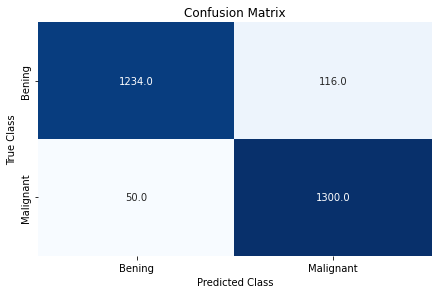


Validation Confusion Matrix


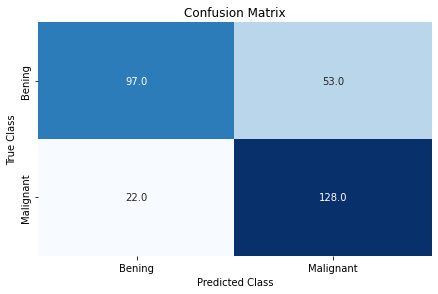

In [39]:
from sklearn.cross_decomposition import PLSRegression  
from sklearn.neighbors           import KNeighborsClassifier

# Number of components and model creation
n_components = 500
plsr = PLSRegression(n_components=n_components)

# Neighbors and classifier creation
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Run experiment
experiment(skin, plsr,knn)

## Random forest + SVM

Training Accuracy = 75.04%
Validation Accuracy = 72.33%

True Positive Rate  (TPR) = 59.33%
False Negative Rate (FNR) = 40.67%
False Positive Rate (FPR) = 14.67%
True Negative Rate  (TPR) = 85.33%

Train Confusion Matrix


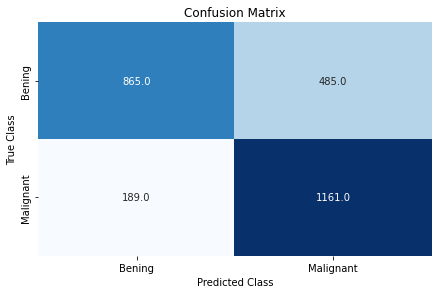


Validation Confusion Matrix


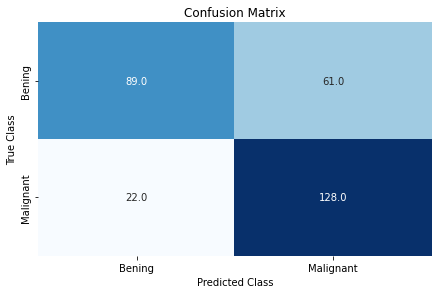

In [40]:
from   sklearn.feature_selection import SelectFromModel
from   sklearn.ensemble          import RandomForestClassifier
from   sklearn.svm               import SVC

# Number of trees, number of selected columns and model creation
n_trees = 500
n_sel   = 1000
rf = SelectFromModel(RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state=0), max_features=n_sel)

# SVM
kernel = 'rbf'
gamma = 'auto'
C = 0.3
svm = SVC(kernel = kernel, gamma=gamma, C=C, random_state=0)

# Run experiment
experiment(skin, rf, svm)

## Random forest + Linear-SVM

Training Accuracy = 89.19%
Validation Accuracy = 74.67%

True Positive Rate  (TPR) = 73.33%
False Negative Rate (FNR) = 26.67%
False Positive Rate (FPR) = 24.00%
True Negative Rate  (TPR) = 76.00%

Train Confusion Matrix


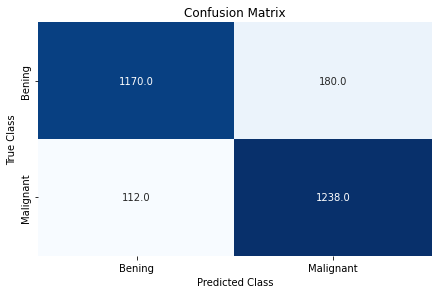


Validation Confusion Matrix


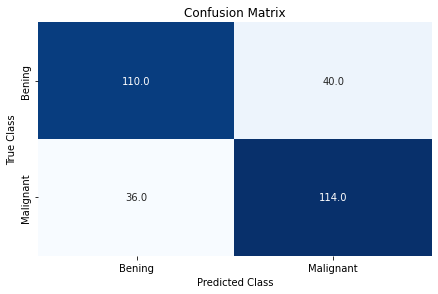

In [41]:
from   sklearn.feature_selection import SelectFromModel
from   sklearn.ensemble          import RandomForestClassifier
from   sklearn.svm               import LinearSVC

# Number of trees, number of selected columns and model creation
n_trees = 500
n_sel   = 1000
rf = SelectFromModel(RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0), max_features=n_sel)

# SVM
C = 0.3
svm = LinearSVC(C=C, random_state=0)

# Run experiment
experiment(skin, rf, svm)

## LogisticRegression + SVM

Training Accuracy = 74.44%
Validation Accuracy = 72.67%

True Positive Rate  (TPR) = 64.67%
False Negative Rate (FNR) = 35.33%
False Positive Rate (FPR) = 19.33%
True Negative Rate  (TPR) = 80.67%

Train Confusion Matrix


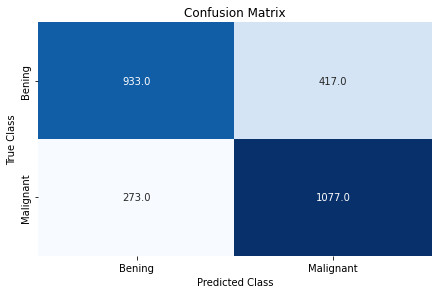


Validation Confusion Matrix


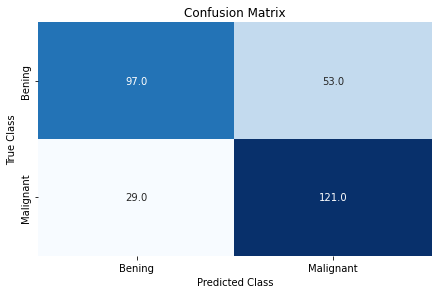

In [42]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model      import LogisticRegression
from sklearn.svm               import SVC

# Number of trees, number of selected columns and model creation
penalty = 'l2'
n_sel   = 1000
logit = SelectFromModel(LogisticRegression(penalty=penalty, random_state=0), max_features=n_sel)

# SVM
kernel = 'rbf'
gamma = 'auto'
C = 0.3
svm = SVC(kernel = kernel, gamma=gamma, C=C, random_state=0)

# Run experiment
experiment(skin, logit, svm)

## PLSR + AdaBoost

In [ ]:
from sklearn.cross_decomposition import PLSRegression  
from sklearn.ensemble            import AdaBoostClassifier

# Number of components and model creation
n_components = 500
plsr = PLSRegression(n_components=n_components)

# Adaboost
n_estimators  = 100
learning_rate = 0.8
ada = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, random_state = 0)

# Run experiment
experiment(skin, plsr, ada)

## Random forest + AdaBoost

Training Accuracy = 88.15%
Validation Accuracy = 72.33%

True Positive Rate  (TPR) = 71.33%
False Negative Rate (FNR) = 28.67%
False Positive Rate (FPR) = 26.67%
True Negative Rate  (TPR) = 73.33%

Train Confusion Matrix


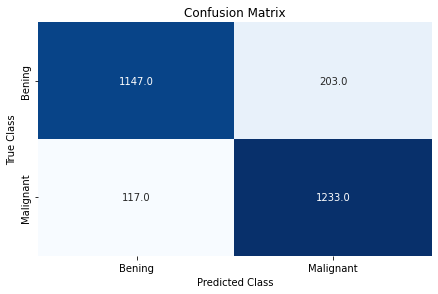


Validation Confusion Matrix


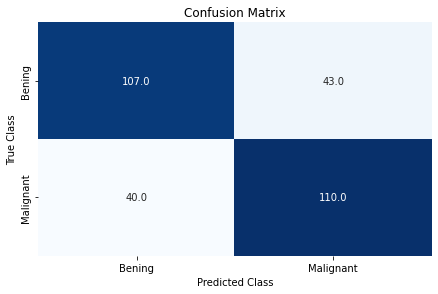

In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier

# Number of trees, number of selected columns and model creation
n_trees = 500
n_sel   = 1000
rf = SelectFromModel(RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0), max_features=n_sel)

# Adaboost
n_estimators  = 100
learning_rate = 0.8
ada = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, random_state = 0)

# Run experiment
experiment(skin, rf, ada)

## Random forest + AdaBoost (SVM)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm               import SVC

# Number of trees, number of selected columns and model creation
n_trees = 500
n_sel   = 1000
rf = SelectFromModel(RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0), max_features=n_sel)

# SVM
kernel = 'rbf'
gamma = 'auto'
C = 0.3
svm = SVC(kernel = kernel, gamma=gamma, C=C, random_state=0)

n_estimators  = 100
learning_rate = 0.8
ada = AdaBoostClassifier(base_estimator=svm, n_estimators=n_estimators, learning_rate = learning_rate, algorithm='SAMME', random_state = 0)

# Run experiment
experiment(skin, rf, ada)

## PLSR + AdaBoost(SVM)-KNN Ensemble

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble            import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm                 import SVC
from sklearn.neighbors           import KNeighborsClassifier

# Number of trees, number of selected columns and model creation
n_trees = 500
n_sel   = 500
rf = SelectFromModel(RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0), max_features=n_sel)

# Number of components and model creation
n_components = 500
plsr = PLSRegression(n_components=n_components)

# Neighbors and classifier creation
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# SVM
kernel = 'rbf'
gamma = 'auto'
C = 0.3
svm = SVC(kernel = kernel, gamma=gamma, C=C, random_state=0)

n_estimators  = 100
learning_rate = 0.8
ada = AdaBoostClassifier(base_estimator=svm, n_estimators=n_estimators, learning_rate = learning_rate, algorithm='SAMME', random_state = 0)

# Voting classifier
vote = VotingClassifier(estimators=[('knn',knn),('ada',ada)], n_jobs=-1)

# Run experiment
experiment(skin, plsr, vote)

## PLSR + SVM-KNN-RF Ensemble

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble            import RandomForestClassifier, VotingClassifier
from sklearn.svm                 import SVC
from sklearn.neighbors           import KNeighborsClassifier

# Number of trees, number of selected columns and model creation
n_trees = 500
rf = RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0)

# Number of components and model creation
n_components = 500
plsr = PLSRegression(n_components=n_components)

# Neighbors and classifier creation
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# SVM
kernel = 'rbf'
gamma = 'auto'
C = 0.3
svm = SVC(kernel = kernel, gamma=gamma, C=C, random_state=0)

# Random forest
n_trees = 500
rf = RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0)

# Voting classifier
vote = VotingClassifier(estimators=[('knn',knn),('svc',svm), ('rf', rf)], n_jobs=-1)

# Run experiment
experiment(skin, plsr, vote)

## PLSR + SVM (rbf)-SVV (linear)-KNN Ensemble

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble            import RandomForestClassifier, VotingClassifier
from sklearn.svm                 import SVC, LinearSVC
from sklearn.neighbors           import KNeighborsClassifier

# Number of trees, number of selected columns and model creation
n_trees = 500
rf = RandomForestClassifier(n_estimators=n_trees, criterion='gini', random_state = 0)

# Number of components and model creation
n_components = 500
plsr = PLSRegression(n_components=n_components)

# Neighbors and classifier creation
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# SVM rbf
kernel = 'rbf'
gamma = 'auto'
C = 0.3
svm_rbf = SVC(kernel = kernel, gamma=gamma, C=C, random_state=0)

# SVM
C = 0.3
svm_linear = LinearSVC(C=C, random_state=0)

# Voting classifier
vote = VotingClassifier(estimators=[('knn',knn),('svc_rbf',svm_rbf), ('svc_linear', svm_linear)], n_jobs=-1)

# Run experiment
experiment(skin, plsr, vote)